In [1]:
using Plots; pyplot();
using DelimitedFiles;
using AugmentedGaussianProcesses;

In [2]:
X = readdlm("data/banana_X_train");
Y = readdlm("data/banana_Y_train")[:];

In [3]:
# Run sparse classification with increasing number of inducing points
Ms = [4, 8, 16, 32, 64]
models = Vector{AbstractGP}(undef,length(Ms)+1)
kernel = RBFKernel(1.0)
for (index, num_inducing) in enumerate(Ms)
    m = SVGP(X, Y, kernel, BayesianSVM(),AnalyticVI(),num_inducing)
    println("Training with $(num_inducing) points")
    @time train!(m,iterations=20)
    models[index] = m;
end

Training with 4 points
 14.340582 seconds (35.16 M allocations: 1.827 GiB, 9.90% gc time)
Training with 8 points
  0.626963 seconds (503.31 k allocations: 152.754 MiB, 3.23% gc time)
Training with 16 points
  0.636855 seconds (503.31 k allocations: 252.417 MiB, 3.17% gc time)
Training with 32 points
  1.524272 seconds (503.31 k allocations: 452.751 MiB, 2.51% gc time)
Training with 64 points
  3.273656 seconds (503.66 k allocations: 857.489 MiB, 2.17% gc time)


In [4]:
model = VGP(X, Y, kernel, BayesianSVM(), AnalyticVI())
println("Training with full model")
@time train!(model,iterations=5);
models[end]  = model;

Training with full model
135.078866 seconds (3.98 M allocations: 12.780 GiB, 3.42% gc time)


In [5]:
function compute_Grid(model,nGrid=50)
    mins = [-3.25,-2.85]
    maxs = [3.65,3.4]
    xlin = range(mins[1],stop=maxs[1],length=nGrid)
    ylin = range(mins[2],stop=maxs[2],length=nGrid)
    Xplot = hcat([j for i in xlin, j in ylin][:],[i for i in xlin, j in ylin][:])
    y = proba_y(model,Xplot)
    return (y,xlin,ylin)
    end;

In [6]:
function plotdata(X,Y)
    Plots.plot(X[Y.==1,1],X[Y.==1,2],t=:scatter,alpha=0.33,markerstrokewidth=0.0,lab="",size=(300,500));
    Plots.plot!(X[Y.==-1,1],X[Y.==-1,2],t=:scatter,alpha=0.33,markerstrokewidth=0.0,lab="")
    end;

In [7]:
function plotcontour(model,X,Y)
    nGrid = 30
    (predic,x,y) = compute_Grid(model,nGrid);
    plotdata(X,Y)
    if in(:Z,fieldnames(typeof(model)))
        Plots.plot!(model.Z[1][:,1],model.Z[1][:,2],msize=2.0,color="black",t=:scatter,lab="")
    end
    return Plots.plot!(x,y,reshape(predic,nGrid,nGrid),cbar=false,t=:contour,levels=[0.5],fill=false,fillalpha=0.2,title=(in(:Z,fieldnames(typeof(model))) ? "M = $(model.nFeatures)" : "full"))
end;

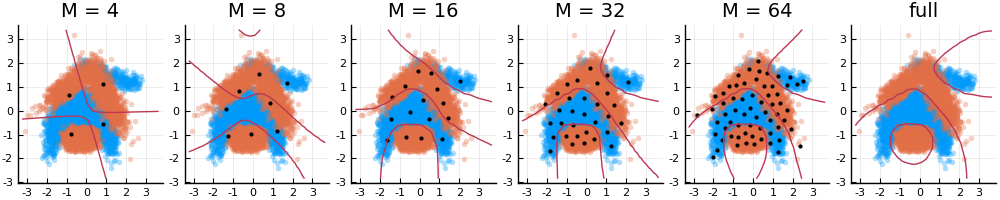

In [8]:
Plots.plot(broadcast(x->plotcontour(x,X,Y),models)...,layout=(1,length(models)),size=(1000,200))